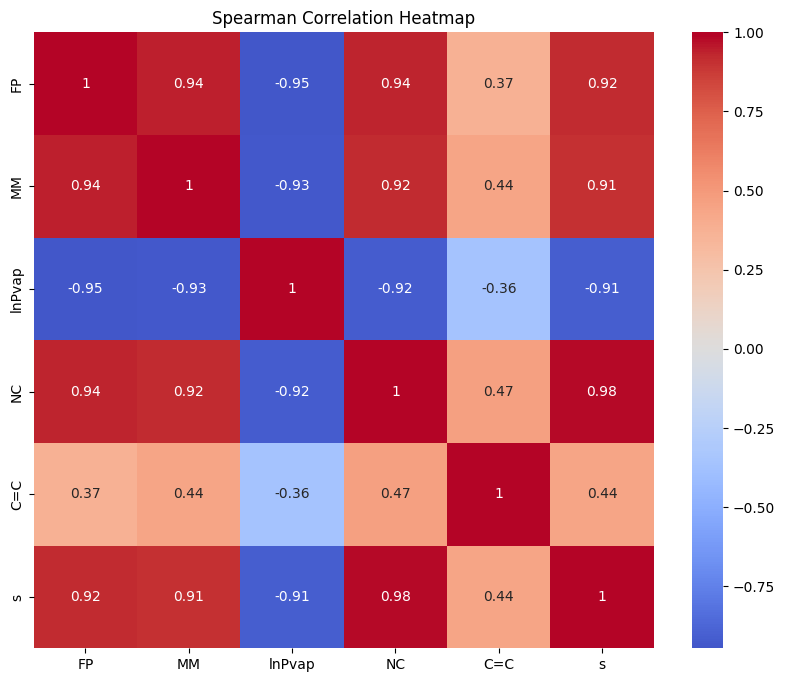

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

fp_data = pd.read_csv("C:/Projetos/fp-neural-net/data/TCC_data.csv")

# Fill NaN values and remove duplicate ones, if exists
fp_data.fillna(0)
fp_data.drop_duplicates()

# Calculate Spearman correlation
selected_columns = ['FP', 'MM', 'lnPvap', 'NC', 'C=C', 's'] # The method column need to be desconsidered, since it related to the FP experimental method
filtered_data = fp_data[selected_columns]
spearman_corr = filtered_data.corr(method="spearman")

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlation Heatmap')
plt.show()


Based on the heatmap analysis, it was observed that the molar mass of the mixture (MM), the natural logarithm of the vapor pressure of the mixture (lnPvap), the number of carbons (NC), and the sum of the entropy of each component in the mixture (s) have a strong correlation with the flash point (FP). Consequently, the number of unsaturations in the carbon chain (C=C) was removed from consideration. Furthermore, due to the strong correlation between NC and s, NC was excluded from the modeling process. Entropy (s) provides detailed molecular information, which can more effectively describe the FP.

In [2]:
import numpy as np
import os
import sys

from sklearn.model_selection import KFold

sys.path.append(os.path.abspath(".."))

from src.model_training import NeuralNet

# Remove NC and C=C
fp_data = fp_data.drop(columns=["NC", "C=C"])

# Split features and label
features = fp_data.iloc[:, 1:].values
label = fp_data.iloc[:, 1].values

# Train model using a cross-validation loop
mae_list = []
rmse_list = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
for train_idx, test_idx in kf.split(features):
    X_train, X_test = features[train_idx], features[test_idx]
    y_train, y_test = label[train_idx], label[test_idx]

    nn_exec = NeuralNet(X_train, X_test, y_train, y_test)
    mae, mse = nn_exec.execute_training_steps()

    mae_list.append(mae)
    rmse_list.append(np.sqrt(mse))

print(f"Average MAE = {np.mean(mae_list)}")
print(f"Average RMSE = {np.mean(rmse_list)}")

3/3 [==============================] - 0s 3ms/step - loss: 1.1311 - mae: 0.3192 - mse: 0.4376
MAE - 0.3191654086112976
RMSE - 0.6615055673109788
Model and scaler were succesfully saved
3/3 [==============================] - 0s 5ms/step - loss: 0.6412 - mae: 0.2259 - mse: 0.1126
MAE - 0.22594107687473297
RMSE - 0.3356046025242194
Model and scaler were succesfully saved
3/3 [==============================] - 0s 6ms/step - loss: 0.9646 - mae: 0.2808 - mse: 0.2790
MAE - 0.2808477282524109
RMSE - 0.5281676743550838
Model and scaler were succesfully saved
3/3 [==============================] - 0s 5ms/step - loss: 0.8350 - mae: 0.2502 - mse: 0.2030
MAE - 0.250213086605072
RMSE - 0.45053852098028224
Model and scaler were succesfully saved
3/3 [==============================] - 0s 3ms/step - loss: 0.7756 - mae: 0.2149 - mse: 0.1736
MAE - 0.21494369208812714
RMSE - 0.4167039039979582
Model and scaler were succesfully saved
Average MAE = 0.2582221984863281
Average RMSE = 0.47850405383370453
